Tutorial at:     
- GitHub: https://github.com/ncar/cesm-lens-aws/   
- Reproduce CESM-LENS: http://gallery.pangeo.io/repos/NCAR/cesm-lens-aws/notebooks/kay-et-al-2015.v3.html    

## Step 0: load necessary packages and define parameters (no need to change)

In [1]:
%%time
# Display output of plots directly in Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
import util

with open("./config.json",'r') as load_f:
#     param = json.loads(json.load(load_f))
    param = json.load(load_f)
    
    city_loc = param["city_loc"]
    catalog_url = param["catalog_url"]
    l_component = param["l_component"]
    a_component = param["a_component"]
    experiment = param["experiment"]
    frequency = param["frequency"]
    cam_ls = param["cam_ls"]
    clm_ls = param["clm_ls"]
    time = slice(param["time_start"],param["time_end"])
    member_id = param["member_id"]
    estimator_list = param["estimator_list"]
    time_budget = param["time_budget"]
    features = param["features"]
    label = param["label"]
    
# get a dataset
ds = util.get_data(city_loc, experiment, frequency, member_id, time, cam_ls, clm_ls, 
                   a_component="atm", l_component="lnd", mask_path = "./urban_mask.nc")

# create a dataframe
ds['time'] = ds.indexes['time'].to_datetimeindex()
df = ds.to_dataframe().reset_index().dropna()

if "PRSN" in features:
    df["PRSN"] = df["PRECSC"] + df["PRECSL"]
    
# setup for automl
automl = AutoML()
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "estimator_list":estimator_list,
}


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


CPU times: user 1min 7s, sys: 47.4 s, total: 1min 54s
Wall time: 35 s


## Step 1: data analysis

**xarray.Dataset**

In [2]:
ds

<xarray.Dataset>
Dimensions:     (member_id: 1, time: 7299)
Coordinates:
    lon         float64 -88.75
  * member_id   (member_id) int64 2
    lat         float64 40.05
  * time        (time) datetime64[ns] 2081-01-02T12:00:00 ... 2100-12-31T12:0...
Data variables:
    TREFHT      (member_id, time) float32 267.5 267.7 275.7 ... 280.6 278.0
    TREFHTMX    (member_id, time) float32 270.9 276.0 283.8 ... 289.3 285.7
    FLNS        (member_id, time) float32 67.13 75.71 53.1 ... 72.42 71.2 62.57
    FSNS        (member_id, time) float32 93.39 89.37 88.2 ... 83.75 89.64 77.89
    PRECSC      (member_id, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRECSL      (member_id, time) float32 3.048e-09 8.637e-10 ... 0.0 0.0
    PRECT       (member_id, time) float32 3.048e-09 8.637e-10 ... 4.164e-10
    QBOT        (member_id, time) float32 0.001285 0.001422 ... 0.004192
    UBOT        (member_id, time) float32 7.931 1.266 -1.619 ... 3.694 -0.1972
    VBOT        (member_id, time) float32 0.4976 2.597 5.257 ... 1.785 0.1336
    TREFMXAV_U  (member_id, time) float32 291.6 271.9 276.9 ... 288.4 289.4

**pandas dataframe**

In [3]:
df.head()

,member_id,time,lon,TREFHT,TREFHTMX,FLNS,FSNS,PRECSC,PRECSL,PRECT,QBOT,UBOT,VBOT,lat,TREFMXAV_U,PRSN
0,2,2081-01-02 12:00:00,-88.75,267.530823,270.858276,67.127922,93.389015,0.0,3.047973e-09,3.047973e-09,0.001285,7.930864,0.497645,40.052357,291.566376,3.047973e-09
1,2,2081-01-03 12:00:00,-88.75,267.687714,276.013184,75.707771,89.367584,0.0,8.636923e-10,8.637052e-10,0.001422,1.265992,2.597399,40.052357,271.861420,8.636923e-10
2,2,2081-01-04 12:00:00,-88.75,275.672028,283.799103,53.098457,88.202408,0.0,1.331122e-09,2.900762e-09,0.001883,-1.618823,5.256704,40.052357,276.851349,1.331122e-09
3,2,2081-01-05 12:00:00,-88.75,276.890686,284.918884,38.585438,43.366203,0.0,0.000000e+00,1.297357e-09,0.004626,-2.739517,5.846395,40.052357,284.498749,0.000000e+00
4,2,2081-01-06 12:00:00,-88.75,287.462036,291.275452,7.098297,38.443039,0.0,1.156371e-14,6.182010e-08,0.009604,-0.635833,8.809414,40.052357,285.547607,1.156371e-14


**data visualization**

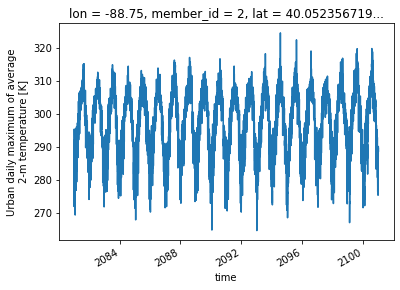

In [4]:
ds["TREFMXAV_U"].plot()

## Step 2: automated machine learning

**train a model (emulator)**

In [5]:
%%time
# assume that we want to split the data into training data and testing data
# let's use first 95% for training, and the remaining for testing 
idx = df.shape[0]
train = df.iloc[:int(0.95*idx),:]
test = df.iloc[int(0.95*idx):,:]
(X_train, y_train) = (train[features], train[label].values)
(X_test, y_test) = (test[features], test[label].values)

# train the model
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings, verbose=-1)
print(automl.model.estimator)

LGBMRegressor(colsample_bytree=0.6649148062238498,
              learning_rate=0.17402065726724145, max_bin=255,
              min_child_samples=3, n_estimators=93, num_leaves=15,
              reg_alpha=0.0009765625, reg_lambda=0.006761362450996487,
              verbose=-1)
CPU times: user 7.62 s, sys: 14.4 s, total: 22 s
Wall time: 15.2 s


**apply and test the machine learning model**      
use `automl.predict(X)` to apply the model

In [6]:
# training data
print("model performance using training data:")
y_pred = automl.predict(X_train)
print("root mean square error:", 
      mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False))
print("r2:", r2_score(y_true=y_train, y_pred=y_pred),"\n")
import pandas as pd
d_train = {"time":train["time"],"y_train":y_train.reshape(-1),"y_pred":y_pred.reshape(-1)}
df_train = pd.DataFrame(d_train).set_index("time")

# testing data
print("model performance using testing data:")
y_pred = automl.predict(X_test)
print("root mean square error:", 
      mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False))
print("r2:", r2_score(y_true=y_test, y_pred=y_pred))
d_test = {"time":test["time"],"y_test":y_test.reshape(-1),"y_pred":y_pred.reshape(-1)}
df_test = pd.DataFrame(d_test).set_index("time")

model performance using training data:
root mean square error: 1.891482463886013
r2: 0.9646972730399841 

model performance using testing data:
root mean square error: 2.4148976103187043
r2: 0.9496869325210374


**visualization**

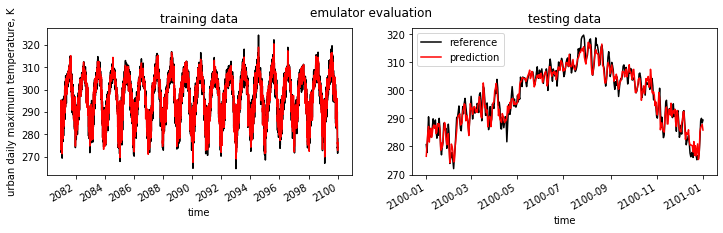

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
fig.suptitle('emulator evaluation')
df_train["y_train"].plot(label="reference",c="k",ax=ax1)
df_train["y_pred"].plot(label="prediction",c="r",ax=ax1)
ax1.set_title("training data")
ax1.set_ylabel("urban daily maximum temperature, K")

df_test["y_test"].plot(label="reference",c="k",ax=ax2)
df_test["y_pred"].plot(label="prediction",c="r",ax=ax2)
ax2.set_title("testing data")
plt.legend()
plt.show()